In [3]:
import pandas as pd
import numpy as np
import os
path_in = os.path.join("Data")  # parent directory
np.random.seed(42)

import sys
sys.path.append(os.path.abspath("../../src/RC-Model"))  # now src is on sys.path

from models import * 
from simulate import *
from plot import *
from train import *
from split_dataset import *

%load_ext autoreload
%autoreload 2

# === Paths ===
###################### ======================== Case Study 1 ======================= ###########################

file_path = os.path.join(path_in, "dataset2.xlsx")
cs1 = pd.read_excel(file_path)

cs1["INDOOR_TEMP"] = cs1[["RTD31", "RTD34", "RTD37", "RTD40", "RTD41"]].mean(axis=1)
# Rename columns
rename_mapping = {
        'Tout': 'OUTDOOR_TEMP',
        'PhRad_actual_power': 'PHI_H',
        'SolGlob': 'PYRANOMETER'
    }
cs1 = cs1.rename(columns=rename_mapping)
# Convert 't' to datetime and set as index

cs1['Time'] = pd.to_datetime(cs1['Time'])
cs1 = cs1.set_index('Time')
cs1_surface_area = 100  # m² 
cs1 = cs1.iloc[0:960]

train_cs1, val_cs1, test_cs1 = split_dataset(cs1, testing_days=3, val_split=0.3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



=== Best result ===
Best Trial Validation #: 7
Best Trial Training #: 4
Best RMSE Validation: 0.1850
RMSE Training of Best Validation : 0.0109
Best RMSE Training: 0.0109
Best initialization Validation: {'R_in_e': 0.08940400954986757, 'R_e_a': 0.19678687955672605, 'R_in_a': 0.04618206162162753, 'C_in': 163339835.0508689, 'C_e': 194949967.55505154, 'Ain': 8.1405438183137, 'Ae': 24.862142400806967, 'fh': 0.3567533266935893}
Best initialization Training: {'R_in_e': 0.06598654139229423, 'R_e_a': 0.9489366517160799, 'R_in_a': 0.9656664010414848, 'C_in': 404390276.7101141, 'C_e': 153002270.81751198, 'Ain': 2.9302536529801158, 'Ae': 20.527022372062056, 'fh': 0.4401524937396013}
Best parameters Validation: {'R_in_e': 0.006564397942691603, 'R_e_a': 0.019515572943750115, 'R_in_a': 0.049206254471843534, 'C_in': 4534592.717291517, 'C_e': 19940356.69159019, 'Ain': 0.9289384398336756, 'Ae': 1.253905946865285, 'fh': 0.24574010843283187, 'Objective': 0.010863475748484924, 'Solve_time': 0.6492218971252

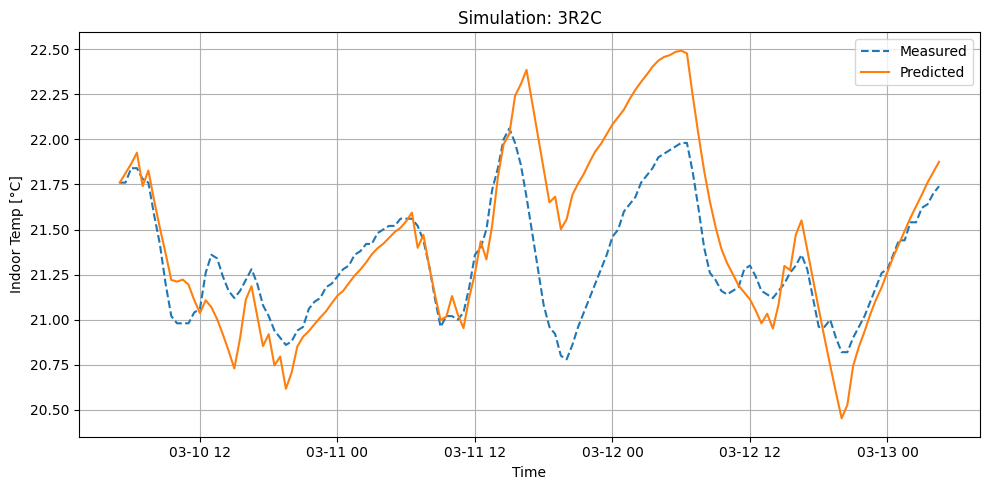

In [ ]:
# --- Bounds ---
bounds_cs1 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs1_surface_area),
    "Ae": (0.0001, 0.3 * cs1_surface_area),
    "fh": (0,1)
}

###################### ======================== Case Study 1 ======================= ###########################

model_3r2c_cs1, parameters_3r2c_cs1, best_initialization_3r2c_cs1, validation_pred_3r2c_cs1, initialize_testing_3r2c_cs1, all_trials_3r2c_cs1 = train_greybox_model_with_validation_process(
    train_df=train_cs1, val_df=val_cs1, model_type="3R2C", bounds=bounds_cs1, 
    num_trials=30, deltaT=1800, show_plot=False, log=False)

initialize_testing_3r2c_cs1['Tin'] = test_cs1['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_3r2c_cs1, testing_df_3r2c_cs1 = simulate_and_evaluate(
        val_df=test_cs1, param_dict=parameters_3r2c_cs1, model_type="3R2C",
        initializations=initialize_testing_3r2c_cs1, show_plot=True
    )


RMSE 3R2C Case Study 1: 0.10 °C


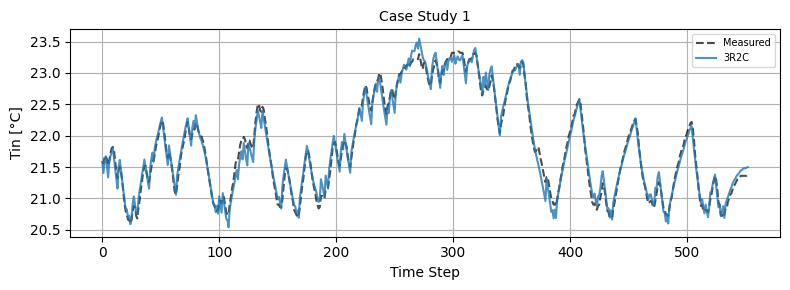

RMSE 3R2C Case Study 1: 0.18 °C


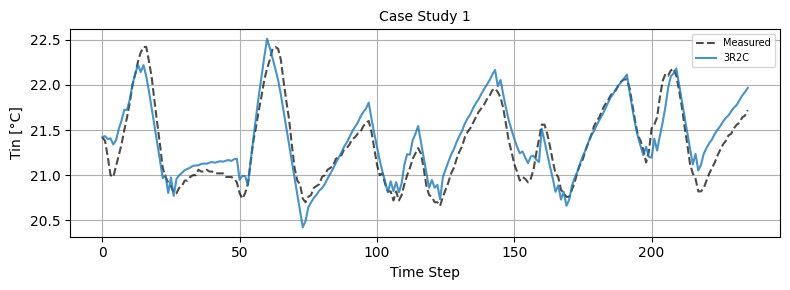

RMSE 3R2C Case Study 3: 0.33 °C


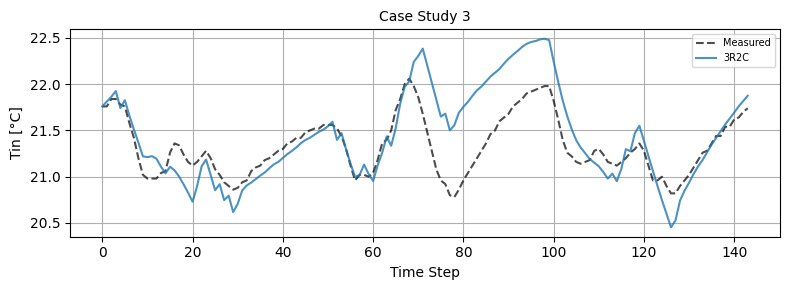

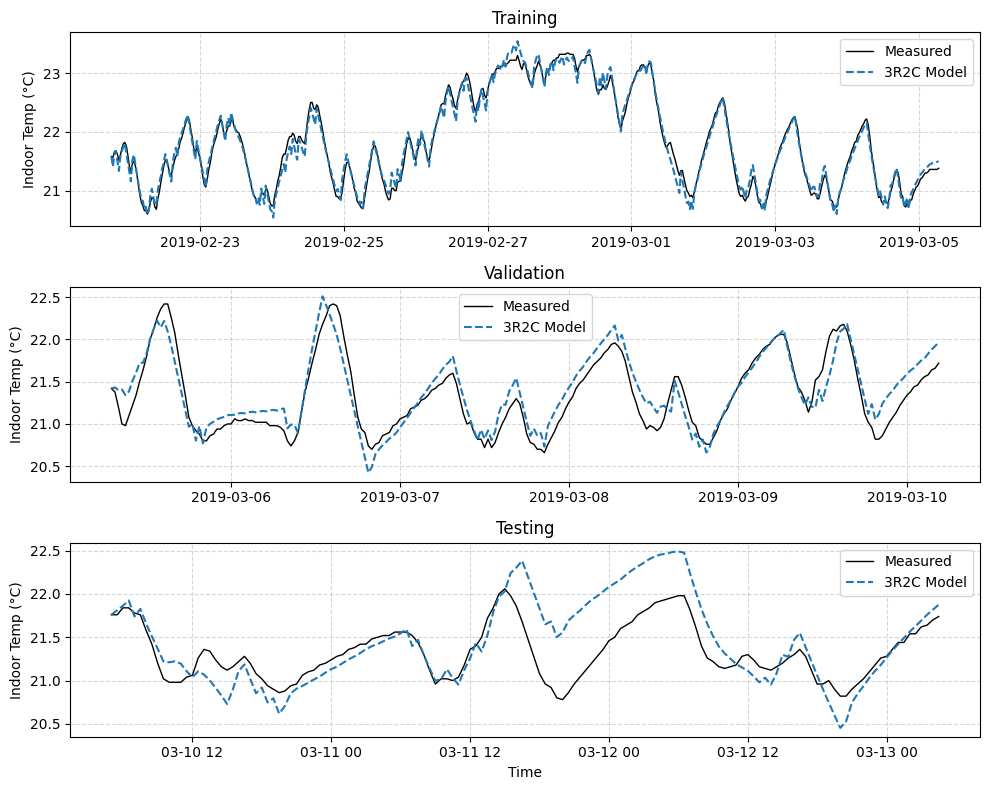

In [22]:
# --- Original plots (keep as before) ---

T_model_3r2c_cs1 = np.array([model_3r2c_cs1.T_in[t]() for t in model_3r2c_cs1.T_in.index_set()])

datasets=[train_cs1]
validation_dataset=[[T_model_3r2c_cs1] ]
labels = ['3R2C']
TC_labels = ['Case Study 1', 'Case Study 2', 'Case Study 3', 'Case Study 4']
plot_model_validation(datasets,validation_dataset,labels,TC_labels, figsize=(8,3))

T_model_3r2c_cs1 = np.array(validation_pred_3r2c_cs1['T_in_estimate'])

datasets=[val_cs1]
validation_dataset=[[T_model_3r2c_cs1]]
labels = ['3R2C']
TC_labels = ['Case Study 1']
plot_model_validation(datasets,validation_dataset,labels, TC_labels, figsize=(8,3))

T_model_3r2c_cs1 = np.array(testing_df_3r2c_cs1['T_in_estimate'])

datasets=[test_cs1]
validation_dataset=[[T_model_3r2c_cs1]]
labels = ['3R2C']
TC_labels = ['Case Study 3']

plot_model_validation(datasets,validation_dataset,labels, TC_labels, figsize=(8,3))

# --- Combined plot in one figure with separate x-axes ---

import matplotlib.pyplot as plt

# Training
T_train_model = np.array([model_3r2c_cs1.T_in[t]() for t in model_3r2c_cs1.T_in.index_set()])
T_train_true = train_cs1['INDOOR_TEMP'].values
time_train = train_cs1.index

# Validation
T_val_model = np.array(validation_pred_3r2c_cs1['T_in_estimate'])
T_val_true = val_cs1['INDOOR_TEMP'].values
time_val = val_cs1.index

# Testing
T_test_model = np.array(testing_df_3r2c_cs1['T_in_estimate'])
T_test_true = test_cs1['INDOOR_TEMP'].values
time_test = test_cs1.index

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=False)

# Training
axs[0].plot(time_train, T_train_true, label='Measured', color='black', linewidth=1)
axs[0].plot(time_train, T_train_model, label='3R2C Model', color='tab:blue', linestyle='--')
axs[0].set_title('Training')
axs[0].set_ylabel('Indoor Temp (°C)')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.5)

# Validation
axs[1].plot(time_val, T_val_true, label='Measured', color='black', linewidth=1)
axs[1].plot(time_val, T_val_model, label='3R2C Model', color='tab:blue', linestyle='--')
axs[1].set_title('Validation')
axs[1].set_ylabel('Indoor Temp (°C)')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.5)

# Testing
axs[2].plot(time_test, T_test_true, label='Measured', color='black', linewidth=1)
axs[2].plot(time_test, T_test_model, label='3R2C Model', color='tab:blue', linestyle='--')
axs[2].set_title('Testing')
axs[2].set_ylabel('Indoor Temp (°C)')
axs[2].set_xlabel('Time')
axs[2].legend()
axs[2].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Computantional Time ##

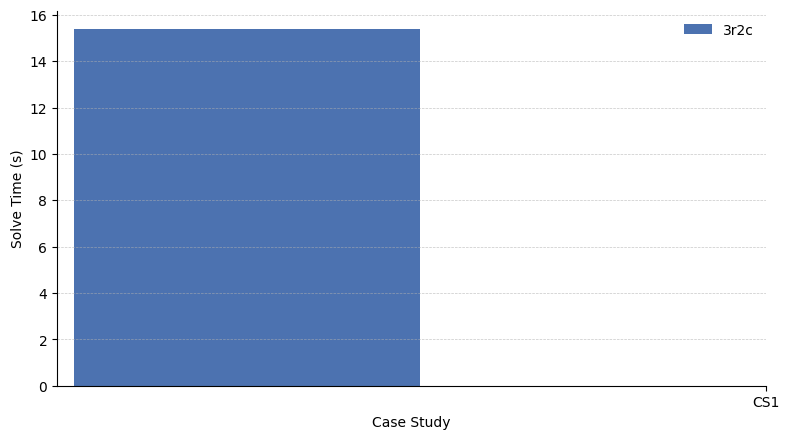

In [15]:
cases = ['CS1']
models = ['3r2c']
solve_times = {
    '3r2c': [
        all_trials_3r2c_cs1['Solve_time'].sum()
    ]
}

x = np.arange(len(cases))
width = 0.18
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b3']

fig, ax = plt.subplots(figsize=(8, 4.5))

for i, model in enumerate(models):
    ax.bar(x + i * width, solve_times[model], width, label=model, color=colors[i])

ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(cases)
ax.set_ylabel("Solve Time (s)")
ax.set_xlabel("Case Study")
ax.legend(frameon=False)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [17]:
def latex_param_row(param_name, param_dicts, cases, fmt="{}"):
    vals = []
    for params in param_dicts:
        val = params.get(param_name, "-")
        if isinstance(val, float):
            val = fmt.format(val)
        vals.append(str(val))
    return " / ".join(vals)

# Collect parameter dictionaries for each model and case
params_3r2c = [parameters_3r2c_cs1]


In [18]:
params_3r2c

[{'R_in_e': 0.006564397942691603,
  'R_e_a': 0.019515572943750115,
  'R_in_a': 0.049206254471843534,
  'C_in': 4534592.717291517,
  'C_e': 19940356.69159019,
  'Ain': 0.9289384398336756,
  'Ae': 1.253905946865285,
  'fh': 0.24574010843283187,
  'Objective': 0.010863475748484924,
  'Solve_time': 0.6492218971252441}]